# ML/DL based models for breast cancer subtype identification

PCA could be run separately.

**Problems I may issue**
* Different platform for data generation (Array, Illumina RNAseq)
* Mapping to a different version of genome
* different normalization
* different sample type

This notebook is used to estimate the number of samples and genes in available breast cancer datasets. It mainly contains some preprocessing steps for the data.

**Data source:**
* http://www.cbioportal.org/study/clinicalData?id=brca_tcga_pan_can_atlas_2018 ~ 1082 samples - probably contains 526 samples from above
* http://www.cbioportal.org/study/summary?id=brca_metabric (Pam50 + Claudin-low subtype in one column) ~ 1904 samples
* http://www.cbioportal.org/study/clinicalData?id=brca_cptac_2020 (PAM50) ~120 samples
* http://www.cbioportal.org/study/clinicalData?id=brca_smc_2018 (PAM50 subtype) ~188 samples
* NKI dataset (R package)
* UPP dataset (R package)
* UNT dataset (R package)
* TRANSBIG dataset (R package)
* GSE96058 (Swedish cohort - Clinical Trial) - only GE data
* GSE81538 (Part II of Swedish cohort) - histological analysis was performed
* ROCK (GSE47561)

I also checked [ICGC](https://dcc.icgc.org/) portal, there is no subtypes for breast and colorectal data.

Single datasets from Gene Expression Omnibus database were processed separately.

**NOTES:**
* So far null values were not filled, filling with 0 is used before processing with DeepCC in 02 step
* So far I select only PAM50 subtypes in preprocessing steps, though the other option can be also to use Other column and add there ERRB2 etc.

**Keywords:** Subtyping, Cancer, Gene Expression, Tumor Microenvironment

**Presentation with preliminary results:**
https://docs.google.com/presentation/d/1p9Rfom5t-wv09leiFySewhunjPq-k9O3ym78R6a5rBo/edit#slide=id.g1546a73b51c_0_4


**A link to other Colab notebooks:**

*Preprocessing of the data:*
* https://colab.research.google.com/drive/1zO8aiRXu2Ob2iYgrv2UtQBpNuGtN_huz?usp=sharing - BRCA cBioPortals
* https://colab.research.google.com/drive/1Sx4EtUk89m2zrN0vzFWnpepKUS2hkEtV?usp=sharing - BRCA GEO datasets
* https://colab.research.google.com/drive/1uRuqeLYd3DzsU-tbnNjd6EaWjJVJUp-g?usp=sharing - CRC
* https://colab.research.google.com/drive/1aw4utUnKIe_W3vH4mtRc3RgzD24c62Nm?usp=sharing - other indications

*Data splitting:*

https://colab.research.google.com/drive/1FoqO_K2jZzqqD49h6zzHFwUWCHT_Ddg4?usp=share_link

*Baseline model implemetation:*

https://colab.research.google.com/drive/1Av4_veo0EgN8hbCwO5hVEVjF7S07lsNS?usp=sharing

*Autoencoder implementation:*

https://colab.research.google.com/drive/1u9VSktxPsmxjkIF38NWc_nMhA_EmRusB?usp=sharing

*A link to the data folder:*

https://drive.google.com/drive/folders/1mD6kZUw7EZS8LbJVg5T0kBDNFwdtq0AH?usp=share_link

## Data Loading and Preparation

In [ ]:
# importing necessary packages
from google.colab import drive
drive.mount('/content/drive')

import re
import os
import warnings
import pandas as pd
import numpy as np
!pip install biomart
import biomart
!pip install GEOparse
import GEOparse

import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA


# constant variables
#path = "/content/drive/MyDrive/MY_DATA/Breast_cancer"
path = "../../"
colors = ['#1b9e77', '#a9f971', '#fdaa48','#6890F0','#A890F0']

In [ ]:
# functions used in this notebook

#the dictionary is used to check/correct consistancy of Subtype column in ROCK dataset
chnge_label = {"1":"Luminal A", "2":"Luminal B", "3":"Her2", "4":"Normal-like", "5":"Basal-like"}

def edit_subtype(row):
  '''
  the function is used to check/correct consistancy of Subtype column
  input: row of dataframe
  output: consistant value 
  '''
  value = ""
  r = str(row["Subtype"])
  if r.startswith("Basal"):
    value = "Basal-like"
  elif r.lower().startswith("her"):
    value = "Her2"
  elif r.startswith("Normal"):
    value = "Normal-like"
  elif r.startswith("claud"):
    value = "Claudin-low"
  elif r in ["Luminal A", "LumA", "LuminalA", "Luma"]:
    value = "Luminal A"
  elif r in ["Luminal B", "LumB", "LuminalB", "Lumb"]:
    value = "Luminal B"
  else:
    value = np.nan
  return value

def get_ensembl_mappings():
  '''
  this function is used to call table for  HUGO gene ID to ENTREZ ID conversion
  '''
  # Set up connection to server 
  import biomart
  from io import StringIO                                             
  server = biomart.BiomartServer('http://ensembl.org/biomart')         
  mart = server.datasets['hsapiens_gene_ensembl']                            
  # List the types of data we want                                            
  response = mart.search({'attributes':  ["affy_hg_u133_plus_2", "hgnc_symbol", "entrezgene_id"]})                          
  data = response.raw.data.decode('ascii')                                    
  
  df = pd.read_csv(StringIO(data), sep="\t", names=["Affymetrix", "Hugo", "Entrez"], header=0)
  df = df.dropna()
  df.Entrez = df.Entrez.astype("int")
  df = df.astype(object)                                                          
  return df

def merge_counts(counts_df, mapping_df, column, index_column, drop_col):
  """
  this function is mainly used for preprocessing of data (Gene IDs to Entrez ID)  
  """
  counts_df = pd.merge(counts_df, df, left_index=True, right_on = f"{column}", how="left")
  counts_df = counts_df.drop_duplicates(f"{index_column}")
  counts_df = counts_df.dropna(subset=[f"{index_column}"])
  counts_df = counts_df.drop([f"{column}", f"{drop_col}"], axis=1)
  counts_df = counts_df.set_index(f"{index_column}")
  counts_df.index.name = f"{index_column}"
  counts_df = counts_df[~counts_df.index.duplicated()]
  counts_df = counts_df[counts_df.index != ""]
  counts_df.sort_index(inplace=True)
  return counts_df

def preprocess_counts_no_merge(counts_df, drop_cols, index_col):
  '''
  this function is used to preprocess counts that have entrez ID initially set
  '''
  counts_df = counts_df.drop(drop_cols, axis=1)
  counts_df = counts_df[counts_df[index_col].notna()]
  counts_df[index_col] = counts_df[index_col].astype(int)
  counts_df = counts_df.set_index(index_col)
  counts_df = counts_df[~counts_df.index.duplicated()]
  counts_df.index = counts_df.index.astype(int)
  counts_df.sort_index(inplace=True)
  return counts_df

def scale_pca(df):
  """
  this function is used to prepare data for visualization with PCA
  """
  sc = StandardScaler()
 
  X_scaled_df = sc.fit_transform(df.T)
  X_scaled_df = pd.DataFrame(X_scaled_df,columns=df.T.columns)
  X_scaled_df.shape

  pca = PCA()
  components = pca.fit_transform(X_scaled_df.T)
  labels = {
    str(i): f"PC {i+1} ({var:.1f}%)"
    for i, var in enumerate(pca.explained_variance_ratio_ * 100)
    }
  return (components, labels)

def process_metadata(metadata_df, study_id, counts_df):
  '''
  this function is used to process metadata of every dataset
  '''
  if study_id in ["NKI", "TRANSBIG", "UPP", "UNT"]:
    metadata_df = pd.merge(metadata_df, dmeta_df, left_on="Sample ID", right_on="Sample ID", how="left")
  metadata_df = metadata_df[["Sample ID", "Subtype"]]
  metadata_df = metadata_df[metadata_df["Sample ID"].isin(counts_df.columns)]
  if study_id == "TCGA":
    metadata_df["Subtype"] = metadata_df["Subtype"].str.split("_").str[-1]
  if study_id == "GSE96058":
    metadata_df = metadata_df[~metadata_df['Sample ID'].str.contains('repl$')]
  metadata_df = metadata_df.astype({"Subtype": 'category'})
  metadata_df["PAM50"] = metadata_df.apply(edit_subtype, axis=1)
  metadata_df = metadata_df[metadata_df['PAM50'].notna()]
  metadata_df = metadata_df[["Sample ID", "PAM50"]]
  metadata_df["Study ID"] = study_id
  return metadata_df


In [ ]:
# path = /content/drive/MyDrive/MY_DATA/
annt_df = pd.read_csv(f"{path}/annotation.csv.zip", compression="zip")
annt_df = annt_df[annt_df["Cancer type"] == "Breast"]
d_ilmn = dict(annt_df[["ID", "Technology"]].values)
len(d_ilmn)

26

In [ ]:
df = get_ensembl_mappings()
df.tail()

Affymetrix     Hugo Entrez
86701    236013_at  CACNA1E    777
86702    238747_at  CACNA1E    777
86703  242410_s_at  CACNA1E    777
86704  201235_s_at     BTG2   7832
86705  201236_s_at     BTG2   7832

In [ ]:
df.shape

(42042, 3)

## TCGA - PanCancer Atlas - 2018

In [ ]:
# loading metadata
tcga_meta_df = pd.read_csv(f"{path}/tcga_pancancer_atlas/brca_tcga_pan_can_atlas_2018_clinical_data.tsv.zip", sep="\t")
tcga_meta_df.shape

(1084, 61)

In [ ]:
tcga_meta_df.head()

Study ID    Patient ID        Sample ID  Diagnosis Age  \
0  brca_tcga_pan_can_atlas_2018  TCGA-3C-AAAU  TCGA-3C-AAAU-01             55   
1  brca_tcga_pan_can_atlas_2018  TCGA-3C-AALI  TCGA-3C-AALI-01             50   
2  brca_tcga_pan_can_atlas_2018  TCGA-3C-AALJ  TCGA-3C-AALJ-01             62   
3  brca_tcga_pan_can_atlas_2018  TCGA-3C-AALK  TCGA-3C-AALK-01             52   
4  brca_tcga_pan_can_atlas_2018  TCGA-4H-AAAK  TCGA-4H-AAAK-01             50   

  Neoplasm Disease Stage American Joint Committee on Cancer Code  \
0                                            STAGE X               
1                                          STAGE IIB               
2                                          STAGE IIB               
3                                           STAGE IA               
4                                         STAGE IIIA               

  American Joint Committee on Cancer Publication Version Type  \
0                                                6TH            
1                                                6TH            
2                                                7TH            
3                                                7TH            
4                                                7TH            

   Aneuploidy Score  Buffa Hypoxia Score    Cancer Type  \
0              19.0                -21.0  Breast Cancer   
1              22.0                  5.0  Breast Cancer   
2              13.0                 -5.0  Breast Cancer   
3               4.0                -27.0  Breast Cancer   
4               7.0                -27.0  Breast Cancer   

  TCGA PanCanAtlas Cancer Type Acronym  ...    Subtype  \
0                                 BRCA  ...  BRCA_LumA   
1                                 BRCA  ...  BRCA_Her2   
2                                 BRCA  ...  BRCA_LumB   
3                                 BRCA  ...  BRCA_LumA   
4                                 BRCA  ...  BRCA_LumA   

   Tissue Prospective Collection Indicator  \
0                                       No   
1                                       No   
2                                       No   
3                                       No   
4                                      Yes   

   Tissue Retrospective Collection Indicator   Tissue Source Site  \
0                                        Yes  Columbia University   
1                                        Yes  Columbia University   
2                                        Yes  Columbia University   
3                                        Yes  Columbia University   
4                                         No    Proteogenex, Inc.   

   Tissue Source Site Code TMB (nonsynonymous)  Tumor Disease Anatomic Site  \
0                       3C            0.800000                       Breast   
1                       3C           15.266667                       Breast   
2                       3C            0.933333                       Breast   
3                       3C            1.500000                       Breast   
4                       4H            0.700000                       Breast   

                       Tumor Type Patient Weight Winter Hypoxia Score  
0  Infiltrating Lobular Carcinoma            NaN                -28.0  
1   Infiltrating Ductal Carcinoma            NaN                 20.0  
2   Infiltrating Ductal Carcinoma            NaN                -10.0  
3   Infiltrating Ductal Carcinoma            NaN                  4.0  
4  Infiltrating Lobular Carcinoma            NaN                -20.0  

[5 rows x 61 columns]

In [ ]:
# reading counts
tcga_count_df = pd.read_csv(f"{path}/tcga_pancancer_atlas/data_mrna_seq_v2_rsem_zscores_ref_all_samples.zip",  sep="\t", index_col=[1])
tcga_count_df = tcga_count_df.drop("Hugo_Symbol", axis=1)
tcga_count_df.index = tcga_count_df.index.astype(int)
tcga_count_df.sort_index(inplace=True)
tcga_count_df.head()

TCGA-3C-AAAU-01  TCGA-3C-AALI-01  TCGA-3C-AALJ-01  \
Entrez_Gene_Id                                                      
1                        0.4344           0.6644           1.3806   
2                       -0.9636          -0.5790          -0.3558   
9                        1.2045          -0.1725           0.2166   
10                       0.4247           2.1151          -1.1072   
12                       0.3958          -2.8225           0.0803   

                TCGA-3C-AALK-01  TCGA-4H-AAAK-01  TCGA-5L-AAT0-01  \
Entrez_Gene_Id                                                      
1                        0.3957           0.8186           0.4756   
2                       -0.0460          -0.2392           0.1239   
9                        0.1931          -0.9395          -0.0174   
10                       0.3018          -1.1322           0.5353   
12                       0.2354           0.0608           0.3638   

                TCGA-5T-A9QA-01  TCGA-A1-A0SB-01  TCGA-A1-A0SD-01  \
Entrez_Gene_Id                                                      
1                        1.0114          -1.2713           0.0320   
2                       -1.8280           1.4813           1.0711   
9                        0.0562          -1.3572           0.4348   
10                      -0.3519          -0.9300           0.2292   
12                      -1.5796          -0.7507           1.3426   

                TCGA-A1-A0SE-01  ...  TCGA-UL-AAZ6-01  TCGA-UU-A93S-01  \
Entrez_Gene_Id                   ...                                     
1                        0.4073  ...          -1.4029           1.0418   
2                        0.4746  ...          -1.2834          -1.6785   
9                        0.8439  ...          -1.0913          -1.1593   
10                       0.2548  ...          -0.8461           1.4662   
12                       0.8384  ...           0.1534          -2.0339   

                TCGA-V7-A7HQ-01  TCGA-W8-A86G-01  TCGA-WT-AB41-01  \
Entrez_Gene_Id                                                      
1                        2.4864           1.6666          -0.1801   
2                       -0.4905           0.6948          -0.2398   
9                       -0.6888           0.8891          -0.3403   
10                       0.5352           0.9908           0.7690   
12                       0.3395           0.3613          -1.1519   

                TCGA-WT-AB44-01  TCGA-XX-A899-01  TCGA-XX-A89A-01  \
Entrez_Gene_Id                                                      
1                        1.5139           0.5883           0.7537   
2                       -1.0636           0.8457           0.5946   
9                        0.7985          -0.6313           0.2911   
10                       1.9597          -0.3735           3.4610   
12                       0.3791           0.4408           0.9100   

                TCGA-Z7-A8R5-01  TCGA-Z7-A8R6-01  
Entrez_Gene_Id                                    
1                        1.4275           0.7202  
2                        1.7012          -0.6240  
9                        0.6993           0.5115  
10                       0.2375          -0.4537  
12                       1.2669           0.9495  

[5 rows x 1082 columns]

In [ ]:
tcga_count_df.shape

(20531, 1082)

In [ ]:
tcga_meta_df = process_metadata(tcga_meta_df, "TCGA", tcga_count_df)
tcga_meta_df.groupby("PAM50")['Sample ID'].count()

PAM50
Basal-like     171
Her2            78
Luminal A      499
Luminal B      197
Normal-like     36
Name: Sample ID, dtype: int64

In [ ]:
tcga_meta_df = tcga_meta_df.dropna()
tcga_meta_df.shape

(981, 3)

In [ ]:
tcga_count_df = tcga_count_df[tcga_meta_df["Sample ID"].tolist()]
tcga_count_df.shape

(20531, 981)

In [ ]:
tcga_meta_df.groupby('PAM50')["Sample ID"].count().plot.bar(color=colors, title="Label counts of TCGA dataset samples", ylabel="Number of samples [-]", xlabel = "PAM50 classification").text(0, 450, f"Total: {tcga_meta_df.shape[0]}",fontsize=12, bbox=dict(facecolor='none', edgecolor='black', boxstyle='round'))

Text(0, 450, 'Total: 981')

In [ ]:
#tcga_count_df.to_csv(f"{path}/all_processed/X_TCGA_BRCA.csv.tar.gz", compression = "gzip")
#tcga_meta_df.to_csv(f"{path}/all_processed/y_TCGA_BRCA.csv.tar.gz", compression = "gzip")

In [ ]:
train_features, test_features, train_targets, test_targets = train_test_split(
        tcga_count_df.T, tcga_meta_df["PAM50"],
        train_size=0.90,
        test_size=0.10,
        random_state=23,
        stratify=tcga_meta_df["PAM50"])

In [ ]:
round(train_targets.value_counts(normalize=True)*100,2)

Luminal A      50.91
Luminal B      20.07
Basal-like     17.46
Her2            7.94
Normal-like     3.63
Name: PAM50, dtype: float64

In [ ]:
round(test_targets.value_counts(normalize=True)*100,2)

Luminal A      50.51
Luminal B      20.20
Basal-like     17.17
Her2            8.08
Normal-like     4.04
Name: PAM50, dtype: float64

In [ ]:
#train_features.to_csv(f"{path}/training_data/X_TCGA_BRCA.csv.tar.gz", compression = "gzip")
#train_targets.to_csv(f"{path}/training_data/y_TCGA_BRCA.csv.tar.gz", compression = "gzip")
#test_features.to_csv(f"{path}/testing_data/X_TCGA_BRCA.csv.tar.gz", compression = "gzip")
#test_targets.to_csv(f"{path}/testing_data/y_TCGA_BRCA.csv.tar.gz", compression = "gzip")

## METABRIC - NO GEO assigned

In [ ]:
# loading metadata
metabric_meta_df = pd.read_csv(f"{path}/METABRIC/brca_metabric_clinical_data.tsv.zip", sep="\t")
metabric_meta_df.rename(columns={'Pam50 + Claudin-low subtype':'Subtype'}, inplace=True)
metabric_meta_df.head()

Study ID Patient ID Sample ID  Age at Diagnosis  \
0  brca_metabric    MB-0000   MB-0000             75.65   
1  brca_metabric    MB-0002   MB-0002             43.19   
2  brca_metabric    MB-0005   MB-0005             48.87   
3  brca_metabric    MB-0006   MB-0006             47.68   
4  brca_metabric    MB-0008   MB-0008             76.97   

  Type of Breast Surgery    Cancer Type  \
0             MASTECTOMY  Breast Cancer   
1      BREAST CONSERVING  Breast Cancer   
2             MASTECTOMY  Breast Cancer   
3             MASTECTOMY  Breast Cancer   
4             MASTECTOMY  Breast Cancer   

                        Cancer Type Detailed Cellularity Chemotherapy  \
0           Breast Invasive Ductal Carcinoma         NaN           NO   
1           Breast Invasive Ductal Carcinoma        High           NO   
2           Breast Invasive Ductal Carcinoma        High          YES   
3  Breast Mixed Ductal and Lobular Carcinoma    Moderate          YES   
4  Breast Mixed Ductal and Lobular Carcinoma        High          YES   

       Subtype  ...  Relapse Free Status (Months) Relapse Free Status  \
0  claudin-low  ...                        138.65      0:Not Recurred   
1         LumA  ...                         83.52      0:Not Recurred   
2         LumB  ...                        151.28          1:Recurred   
3         LumB  ...                        162.76      0:Not Recurred   
4         LumB  ...                         18.55          1:Recurred   

  Number of Samples Per Patient  Sample Type     Sex  \
0                             1      Primary  Female   
1                             1      Primary  Female   
2                             1      Primary  Female   
3                             1      Primary  Female   
4                             1      Primary  Female   

  3-Gene classifier subtype TMB (nonsynonymous) Tumor Size Tumor Stage  \
0                 ER-/HER2-            0.000000       22.0         2.0   
1     ER+/HER2- High Prolif            2.615035       10.0         1.0   
2                       NaN            2.615035       15.0         2.0   
3                       NaN            1.307518       25.0         2.0   
4     ER+/HER2- High Prolif            2.615035       40.0         2.0   

  Patient's Vital Status  
0                 Living  
1                 Living  
2        Died of Disease  
3                 Living  
4        Died of Disease  

[5 rows x 39 columns]

In [ ]:
metabric_meta_df.shape

(2509, 39)

In [ ]:
# loading counts
metabric_count_df = pd.read_csv(f"{path}/METABRIC/data_mrna_agilent_microarray.txt.zip", sep="\t")
metabric_count_df = preprocess_counts_no_merge(metabric_count_df, "Hugo_Symbol", "Entrez_Gene_Id")
metabric_count_df.head()

MB-0362    MB-0346    MB-0386    MB-0574    MB-0503  \
Entrez_Gene_Id                                                          
1                5.607785   5.515704   5.581684   5.602209   5.443726   
2                7.653319   6.564312   8.201633   7.587296   7.545219   
9               10.628267   6.639451  10.330668   9.170203   8.658371   
10               5.639788   5.373945   5.483768   5.987228   5.468384   
12              13.582444  10.207710  11.789055  13.731758  12.564908   

                  MB-0641    MB-0201    MB-0218    MB-0316    MB-0189  ...  \
Entrez_Gene_Id                                                         ...   
1                5.374949   5.625163   5.533212   5.359228   5.468251  ...   
2                8.693606   8.898809   8.763382   9.100264   9.990596  ...   
9                9.569676   5.733174   9.629111   6.176382   6.342962  ...   
10               6.131064   5.119602   5.467175   5.522088   5.609751  ...   
12              12.296457  10.565046  14.300028  11.986363  12.175344  ...   

                  MB-6122    MB-6192    MB-4820   MB-5527    MB-5167  \
Entrez_Gene_Id                                                         
1                5.302562   5.511685   5.627259  5.456827   5.455892   
2                7.850466   7.736627   9.005442  8.696260   8.796967   
9                8.431149   8.560524   8.613745  6.332610  10.297384   
10               5.349204   5.414660   5.238348  5.525921   5.231243   
12              12.409417  11.108355  13.731721  7.993557  14.169804   

                  MB-5465    MB-5453    MB-5471    MB-5127    MB-4313  
Entrez_Gene_Id                                                         
1                5.283639   5.361517   5.432268   5.620578   5.799607  
2               10.127953  11.078945   8.714076   8.333257  10.018235  
9                5.977021   6.282221   8.899801  11.060929   8.317049  
10               5.351139   5.221490   6.692538   5.817706   6.067807  
12              11.175380  13.230864  10.681164  14.169804  11.610352  

[5 rows x 1904 columns]

In [ ]:
metabric_count_df.shape

(18207, 1904)

In [ ]:
metabric_meta_df = process_metadata(metabric_meta_df, "METABRIC", metabric_count_df)
metabric_meta_df.groupby("PAM50")['Sample ID'].count()

PAM50
Basal-like     199
Claudin-low    199
Her2           220
Luminal A      679
Luminal B      461
Normal-like    140
Name: Sample ID, dtype: int64

In [ ]:
metabric_meta_df.shape

(1898, 3)

In [ ]:
metabric_count_df = metabric_count_df[metabric_meta_df["Sample ID"].tolist()]
metabric_count_df.shape

(18207, 1898)

In [ ]:
metabric_meta_df.groupby('PAM50')["Sample ID"].count().plot.bar(color=colors, title="Label counts of METABRIC dataset samples", ylabel="Number of samples [-]", xlabel = "PAM50 classification").text(0, 600, f"Total: {metabric_meta_df.shape[0]}",fontsize=12, bbox=dict(facecolor='none', edgecolor='black', boxstyle='round'))

Text(0, 600, 'Total: 1898')

In [ ]:
#metabric_count_df.to_csv(f"{path}/all_processed/X_METABRIC_BRCA.csv.tar.gz", compression = "gzip")
#metabric_meta_df.to_csv(f"{path}/all_processed/y_METABRIC_BRCA.csv.tar.gz", compression = "gzip")

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(
        metabric_count_df.T, metabric_meta_df["PAM50"],
        train_size=0.90,
        test_size=0.10,
        random_state=23,
        stratify=metabric_meta_df["PAM50"])

In [ ]:
round(y_test.value_counts(normalize=True)*100,2)

Luminal A      35.79
Luminal B      24.21
Her2           11.58
Claudin-low    10.53
Basal-like     10.53
Normal-like     7.37
Name: PAM50, dtype: float64

In [ ]:
round(y_train.value_counts(normalize=True)*100,2)

Luminal A      35.77
Luminal B      24.30
Her2           11.59
Basal-like     10.48
Claudin-low    10.48
Normal-like     7.38
Name: PAM50, dtype: float64

In [ ]:
#x_train.to_csv(f"{path}/training_data/X_METABRIC_BRCA.csv.tar.gz", compression = "gzip")
#y_train.to_csv(f"{path}/training_data/y_METABRIC_BRCA.csv.tar.gz", compression = "gzip")
#x_test.to_csv(f"{path}/testing_data/X_METABRIC_BRCA.csv.tar.gz", compression = "gzip")
#y_test.to_csv(f"{path}/testing_data/y_METABRIC_BRCA.csv.tar.gz", compression = "gzip")

## CPTAC (2020) NO GEO assigned

In [ ]:
cptac_meta_df = pd.read_csv(f"{path}/cptac_2020/brca_cptac_2020_clinical_data.tsv.zip", sep="\t")
cptac_meta_df.rename(columns={'PAM50':'Subtype'}, inplace=True)
cptac_meta_df.shape

(122, 19)

In [ ]:
cptac_meta_df.head()

Patient ID  Sample ID  Mutation Count   Age     Sex  \
0  CPT000814  CPT000814              82   NaN     NaN   
1  CPT001846  CPT001846              72   NaN     NaN   
2   X01BR001   X01BR001              71  55.0  Female   
3   X01BR008   X01BR008             122   NaN     NaN   
4   X01BR009   X01BR009             112   NaN     NaN   

   Chromosome INstability index CIN                   Ethnicity Subtype  \
0                           2.271946  Black or African American   Basal   
1                           0.826617                      White   Basal   
2                           1.137609  Black or African American   Basal   
3                           0.466992                        NaN   Basal   
4                           4.302139                        NaN   Basal   

  Tumor Stage APOBEC Signature CD3 TILS Counts CD3 TILS Status  \
0   Stage IIA                N   not performed   not performed   
1   Stage III                N   not performed   not performed   
2   Stage IIB                N   not performed   not performed   
3         NaN                N   not performed   not performed   
4         NaN                N   not performed   not performed   

   CIBERSORT Absolute Score ER Updated Clinical Status  ERBB2 Gene Amplified  \
0                  0.565019                   Negative                     0   
1                  0.785537                   Negative                     0   
2                  0.454490                   Negative                     0   
3                  2.064309                        NaN                     0   
4                  1.191462                   Negative                     0   

  ERBB2 Proteogenomic Status ERBB2 Updated Clinical Status  \
0                   Negative                           NaN   
1                   Negative                           NaN   
2                   Negative                      Negative   
3                   Negative                           NaN   
4                   Negative                           NaN   

   ESTIMATE Immune Score  ESTIMATE Stromal Score  
0             846.350897             -812.409581  
1            1425.391899              495.603750  
2             475.804314             -476.863678  
3            2809.591640              -77.281727  
4            1664.855380              725.734350

In [ ]:
cptac_count_df = pd.read_csv(f"{path}/cptac_2020/data_mrna_seq_fpkm.txt.zip", sep="\t", index_col=0)
cptac_count_df = merge_counts(cptac_count_df, df, "Hugo", "Entrez", "Affymetrix")
cptac_count_df.shape

(17419, 122)

In [ ]:
cptac_meta_df = process_metadata(cptac_meta_df, "CPTAC", cptac_count_df)
cptac_meta_df.groupby("PAM50").count()["Sample ID"]

PAM50
Basal-like     29
Her2           14
Luminal A      57
Luminal B      17
Normal-like     5
Name: Sample ID, dtype: int64

In [ ]:
cptac_meta_df.shape

(122, 3)

In [ ]:
cptac_count_df = cptac_count_df[cptac_meta_df["Sample ID"].tolist()]
cptac_count_df.shape

(17419, 122)

Text(0, 50, 'Total: 122')

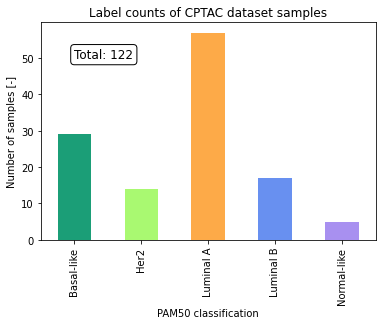

In [ ]:
cptac_meta_df.groupby('PAM50')["Sample ID"].count().plot.bar(color=colors, title="Label counts of CPTAC dataset samples", ylabel="Number of samples [-]", xlabel = "PAM50 classification").text(0, 50, f"Total: {cptac_meta_df.shape[0]}",fontsize=12, bbox=dict(facecolor='none', edgecolor='black', boxstyle='round'))

In [ ]:
#cptac_count_df.to_csv(f"{path}/all_processed/X_CPTAC_BRCA.csv.tar.gz", compression = "gzip")
#cptac_meta_df.to_csv(f"{path}/all_processed/y_CPTAC_BRCA.csv.tar.gz", compression = "gzip")

In [ ]:
X_tra, X_te, y_tra, y_te = train_test_split(
        cptac_count_df.T, cptac_meta_df["PAM50"],
        train_size=0.90,
        test_size=0.10,
        random_state=23,
        stratify=cptac_meta_df["PAM50"])

In [ ]:
round(y_tra.value_counts(normalize=True)*100,2)

Luminal A      46.79
Basal-like     23.85
Luminal B      13.76
Her2           11.93
Normal-like     3.67
Name: PAM50, dtype: float64

In [ ]:
round(y_te.value_counts(normalize=True)*100,2)

Luminal A      46.15
Basal-like     23.08
Luminal B      15.38
Her2            7.69
Normal-like     7.69
Name: PAM50, dtype: float64

In [ ]:
#X_tra.to_csv(f"{path}/training_data/X_cptac_BRCA.csv.tar.gz", compression = "gzip")
#y_tra.to_csv(f"{path}/training_data/y_cptac_BRCA.csv.tar.gz", compression = "gzip")
#X_te.to_csv(f"{path}/testing_data/X_cptac_BRCA.csv.tar.gz", compression = "gzip")
#y_te.to_csv(f"{path}/testing_data/y_cptac_BRCA.csv.tar.gz", compression = "gzip")

## SMC (2018) - (Korean cohort,  GSE113184)

In this dataset columns in counts and metadata do not fit. Edit it and save both dataframes.

In [ ]:
smc2018_meta_df = pd.read_csv(f"{path}/smc_2018/brca_smc_2018_clinical_data.tsv.zip",  sep="\t")
smc2018_meta_df.rename(columns={'PAM50 subtype':'Subtype'}, inplace=True)
smc2018_meta_df.head()

Patient ID               Sample ID  \
0  brca_smc_2018_BB01_002  brca_smc_2018_BB01_002   
1  brca_smc_2018_BB01_004  brca_smc_2018_BB01_004   
2  brca_smc_2018_BB01_005  brca_smc_2018_BB01_005   
3  brca_smc_2018_BB01_006  brca_smc_2018_BB01_006   
4  brca_smc_2018_BB01_007  brca_smc_2018_BB01_007   

               Cancer Type Detailed  Mutation Count  Diagnosis Age  \
0  Breast Invasive Ductal Carcinoma            20.0          58.91   
1  Breast Invasive Ductal Carcinoma             6.0          46.69   
2  Breast Invasive Ductal Carcinoma            35.0          50.84   
3  Breast Invasive Ductal Carcinoma            55.0          52.64   
4  Breast Invasive Ductal Carcinoma            27.0          46.96   

  Chemotherapy Cohort  Cytolytic Activity Score        Histology   \
0           No    IBC                 11.655878  Ductal Carcinoma   
1           No    IBC                 61.077345  Ductal Carcinoma   
2           No    IBC                 11.329466  Ductal Carcinoma   
3           No    IBC                  5.988873  Ductal Carcinoma   
4          Yes    IBC                  6.635089  Ductal Carcinoma   

  Immunohistochemistry Subtype Menopausal Status At Diagnosis  \
0                          ER+                           Post   
1                           TN                            Pre   
2                     ER+HER2+                            Pre   
3                          ER+                           Post   
4                           UA                            Pre   

   Mutation Burden Oncotree Code   Subtype  
0          1.30103           IDC  LuminalB  
1          0.69897           IDC     Basal  
2          1.54407           IDC  LuminalB  
3          1.75587           IDC  LuminalB  
4          1.44716           IDC  LuminalB

In [ ]:
smc2018_count_df = pd.read_csv(f"{path}/smc_2018/data_mrna_seq_tpm_zscores_ref_all_samples.zip", sep="\t")
smc2018_count_df = preprocess_counts_no_merge(smc2018_count_df, "Entrez_Gene_Id", "Hugo_Symbol")
smc2018_count_df = merge_counts(smc2018_count_df, df, "Hugo", "Entrez", "Affymetrix")
smc2018_count_df.shape

(17540, 168)

In [ ]:
smc2018_count_df.head()

brca_smc_2018_BB01_002  brca_smc_2018_BB01_004  \
Entrez                                                   
1                       0.1424                 -0.3950   
2                      -0.2089                  1.2484   
9                      -0.3966                 -0.4969   
10                     -0.4022                  0.1755   
12                     -0.9166                 -0.5486   

        brca_smc_2018_BB01_005  brca_smc_2018_BB01_006  \
Entrez                                                   
1                       0.0690                  0.6187   
2                      -0.1715                  0.0272   
9                      -0.9528                  0.6013   
10                     -0.2428                  0.0283   
12                      0.2177                 -0.5956   

        brca_smc_2018_BB01_007  brca_smc_2018_BB01_008  \
Entrez                                                   
1                      -0.3344                 -0.7266   
2                       0.0794                  0.0548   
9                      -0.7168                  1.7149   
10                     -0.8931                  0.6212   
12                      1.3113                 -0.3160   

        brca_smc_2018_BB01_009  brca_smc_2018_BB01_010  \
Entrez                                                   
1                       0.4011                 -0.4657   
2                       0.5795                  0.3256   
9                       0.4172                 -0.1516   
10                     -0.3341                  0.4644   
12                     -0.4763                 -0.7911   

        brca_smc_2018_BB01_011  brca_smc_2018_BB01_012  ...  \
Entrez                                                  ...   
1                       1.5346                  0.4141  ...   
2                       0.4089                  0.3384  ...   
9                       0.3625                 -0.0949  ...   
10                     -0.8931                 -0.7872  ...   
12                      1.5448                  0.5339  ...   

        brca_smc_2018_BR418  brca_smc_2018_BR419  brca_smc_2018_BR414  \
Entrez                                                                  
1                    0.1653               0.2076               0.6956   
2                   -0.1922              -0.1506              -1.1450   
9                    0.0746               0.0284               0.9258   
10                  -0.2685              -0.0847              -0.1081   
12                   1.5192              -0.2021               0.2447   

        brca_smc_2018_BR437  brca_smc_2018_BR431  brca_smc_2018_BR442  \
Entrez                                                                  
1                    1.0341               0.6036               1.1606   
2                    0.7362               0.2976               0.4027   
9                    0.5788              -0.0572              -0.4928   
10                  -0.1319              -0.5922              -0.3076   
12                   1.3452               2.0195              -0.0494   

        brca_smc_2018_BR457  brca_smc_2018_BR469  brca_smc_2018_BR064  \
Entrez                                                                  
1                    1.4550               0.5456              -1.9925   
2                   -1.2146               0.2982              -0.5862   
9                   -0.2963               1.0040               0.5608   
10                  -0.3610               0.0609              -0.3746   
12                  -1.3149               1.0919               1.0534   

        brca_smc_2018_BR077  
Entrez                       
1                   -1.8268  
2                    0.7406  
9                    0.0875  
10                  -0.6233  
12                   0.8017  

[5 rows x 168 columns]

In [ ]:
smc2018_meta_df = process_metadata(smc2018_meta_df, "smc_2018", smc2018_count_df)
smc2018_meta_df.groupby("PAM50")["Sample ID"].count()

PAM50
Basal-like     36
Her2           18
Luminal A      47
Luminal B      65
Normal-like     2
Name: Sample ID, dtype: int64

In [ ]:
smc2018_meta_df.shape

(168, 3)

In [ ]:
smc2018_count_df = smc2018_count_df[smc2018_meta_df["Sample ID"].tolist()]
smc2018_count_df = smc2018_count_df[~smc2018_count_df.index.duplicated()]
smc2018_count_df.sort_index(inplace=True)
smc2018_count_df.shape

(17540, 168)

Text(0, 55, 'Total: 168')

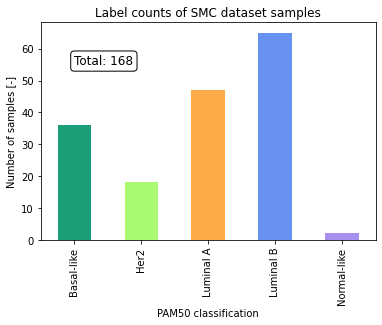

In [ ]:
smc2018_meta_df.groupby('PAM50')["Sample ID"].count().plot.bar(color=colors, title="Label counts of SMC dataset samples", ylabel="Number of samples [-]", xlabel = "PAM50 classification").text(0, 55, f"Total: {smc2018_meta_df.shape[0]}",fontsize=12, bbox=dict(facecolor='none', edgecolor='black', boxstyle='round'))

In [ ]:
#smc2018_count_df.to_csv(f"{path}/all_processed/X_SMC_BRCA.csv.tar.gz", compression = "gzip")
#smc2018_meta_df.to_csv(f"{path}/all_processed/y_SMC_BRCA.csv.tar.gz", compression = "gzip")

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
        smc2018_count_df.T, smc2018_meta_df["PAM50"],
        train_size=0.90,
        test_size=0.10,
        random_state=23,
        stratify=smc2018_meta_df["PAM50"])

In [ ]:
round(y_train.value_counts(normalize=True)*100,2)

Luminal B      39.07
Luminal A      27.81
Basal-like     21.19
Her2           10.60
Normal-like     1.32
Name: PAM50, dtype: float64

In [ ]:
round(y_test.value_counts(normalize=True)*100,2)

Luminal B     35.29
Luminal A     29.41
Basal-like    23.53
Her2          11.76
Name: PAM50, dtype: float64

In [ ]:
#X_train.to_csv(f"{path}/training_data/X_SMC_BRCA.csv.tar.gz", compression = "gzip")
#y_train.to_csv(f"{path}/training_data/y_SMC_BRCA.csv.tar.gz", compression = "gzip")
#X_test.to_csv(f"{path}/testing_data/X_SMC_BRCA.csv.tar.gz", compression = "gzip")
#y_test.to_csv(f"{path}/testing_data/y_SMC_BRCA.csv.tar.gz", compression = "gzip")

## GSE96058 (Swedish cohort)

ClinicalTrials.gov identifier: NCT02306096

### Metadata

In [ ]:
geo ="GSE96058"
gse = GEOparse.get_GEO(geo=geo, destdir='./', silent=True)

gse96058_d = {}
for gsm_name, gsm in gse.gsms.items():
  gse96058_d[gsm.metadata["title"][0]] = gsm.metadata["characteristics_ch1"][20][15:]

In [ ]:
gse96058_meta_df = pd.DataFrame(gse96058_d.items())
gse96058_meta_df.columns = ["Sample ID", "Subtype"]

In [ ]:
gse96058_meta_df.shape

(3409, 2)

### Count matrix

Count matrix was downloaded from https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE96058 metadata was loaded via GEOparse package.

In [ ]:
gse96058_count_df = pd.read_csv(f"{path}/GSE96058/GSE96058_gene_expression_3273_samples_and_136_replicates_transformed.csv.zip", index_col=0)
gse96058_count_df = merge_counts(gse96058_count_df, df, "Hugo", "Entrez", "Affymetrix")
gse96058_count_df.head()

F1         F2        F3        F4        F5        F6  \
Entrez                                                                 
1        0.598115   2.363673  2.647738  1.378576  2.759643  2.287331   
2        6.172477   7.113514  5.641996  7.236769  7.508171  9.701680   
9        1.605137   7.662760  2.849914  6.974007  4.076756  1.097102   
10      -2.351626  -3.321928 -3.321928 -0.859745 -2.026123 -3.321928   
12      10.291038  11.025054  3.998714  7.805376  4.960846  7.347768   

              F7        F8        F9       F10  ...  F2974repl  F3006repl  \
Entrez                                          ...                         
1       1.404053  1.767546  3.082967  2.391895  ...   0.737636   2.842583   
2       8.041422  8.244968  6.697515  7.306434  ...   6.494338   6.265418   
9       1.981681  3.191443  1.416926  3.733380  ...   3.026687   1.917900   
10     -0.118744 -2.171849 -2.994729 -1.849633  ...  -1.092592  -3.321928   
12      6.770758  5.939775  5.322135  7.292353  ...   6.940293   5.341759   

        F3028repl  F3057repl  F3058repl  F3085repl  F3127repl  F3135repl  \
Entrez                                                                     
1        1.777385   1.418644   2.400974   3.437225   0.693220   1.487851   
2        7.319977   8.223603   6.501812   4.870941   6.377099   8.077915   
9        6.127962   3.812736   4.340904   5.148111   2.103732   0.646387   
10      -0.634968  -0.917910  -1.752315  -1.792567  -2.506131  -0.179804   
12       6.708075   8.901877   3.403029  10.697190   7.901593   5.787897   

        F3250repl  F3265repl  
Entrez                        
1        0.885076   2.664302  
2        7.406075   6.830662  
9        1.678737   6.674637  
10      -2.441619  -1.860363  
12       2.022718   8.875006  

[5 rows x 3409 columns]

In [ ]:
gse96058_count_df.shape

(17988, 3409)

In [ ]:
gse96058_count_df.isna().sum().sum()

0

In [ ]:
gse96058_meta_df = process_metadata(gse96058_meta_df, "GSE96058", gse96058_count_df)
gse96058_meta_df.groupby("PAM50")["Sample ID"].count()

PAM50
Basal-like      339
Her2            327
Luminal A      1657
Luminal B       729
Normal-like     221
Name: Sample ID, dtype: int64

Text(0, 1450, 'Total: 3273')

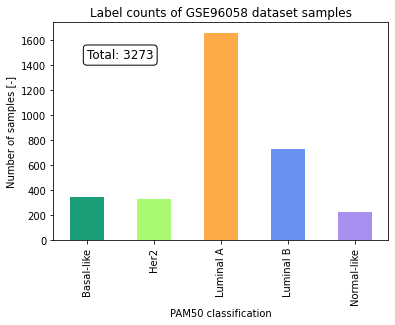

In [ ]:
gse96058_meta_df.groupby('PAM50')["Sample ID"].count().plot.bar(color=colors, title="Label counts of GSE96058 dataset samples", ylabel="Number of samples [-]", xlabel = "PAM50 classification").text(0, 1450, f"Total: {gse96058_meta_df.shape[0]}",fontsize=12, bbox=dict(facecolor='none', edgecolor='black', boxstyle='round'))

In [ ]:
gse96058_count_df = gse96058_count_df[gse96058_meta_df["Sample ID"].tolist()]

In [ ]:
#gse96058_count_df.to_csv(f"{path}/all_processed/X_gse96058_BRCA.csv.tar.gz", compression = "gzip")
#gse96058_meta_df.to_csv(f"{path}/all_processed/y_gse96058_BRCA.csv.tar.gz", compression = "gzip")

In [ ]:
X_tr, X_t, y_tr, y_t = train_test_split(
        gse96058_count_df.T, gse96058_meta_df["PAM50"],
        train_size=0.90,
        test_size=0.10,
        random_state=23,
        stratify=gse96058_meta_df["PAM50"])

In [ ]:
round(y_tr.value_counts(normalize=True)*100,2)

Luminal A      50.63
Luminal B      22.28
Basal-like     10.36
Her2            9.98
Normal-like     6.76
Name: PAM50, dtype: float64

In [ ]:
round(y_t.value_counts(normalize=True)*100,2)

Luminal A      50.61
Luminal B      22.26
Basal-like     10.37
Her2           10.06
Normal-like     6.71
Name: PAM50, dtype: float64

In [ ]:
#X_tr.to_csv(f"{path}/training_data/X_gse96058_BRCA.csv.tar.gz", compression = "gzip")
#y_tr.to_csv(f"{path}/training_data/y_gse96058_BRCA.csv.tar.gz", compression = "gzip")
#X_t.to_csv(f"{path}/testing_data/X_gse96058_BRCA.csv.tar.gz", compression = "gzip")
#y_t.to_csv(f"{path}/testing_data/y_gse96058_BRCA.csv.tar.gz", compression = "gzip")

## GSE81538

### Metadata

In [ ]:
geo ="GSE81538"
gse = GEOparse.get_GEO(geo=geo, destdir='./', silent=True)

gse81538_d = {}
for gsm_name, gsm in gse.gsms.items():
  gse81538_d[gsm.metadata["title"][0]] = gsm.metadata["characteristics_ch1"][37][15:]

In [ ]:
gse81538_meta_df = pd.DataFrame(gse81538_d.items())
gse81538_meta_df.columns = ["Sample ID", "Subtype"]

### Count matrix

In [ ]:
gse81538_count_df = pd.read_csv(f"{path}/GSE81538/GSE81538_gene_expression_405_transformed.csv.zip", index_col=0)
gse81538_count_df = gse81538_count_df[gse81538_meta_df["Sample ID"].tolist()]
gse81538_count_df = merge_counts(gse81538_count_df, df, "Hugo", "Entrez", "Affymetrix")
gse81538_count_df.head()

T1        T2        T3        T4        T5        T6        T7  \
Entrez                                                                          
1        1.590427  0.782005  5.124489  3.537580  3.874691  2.272538  3.550594   
2       10.532488  4.758267  5.989012  7.436564  6.752650  6.035074  7.284499   
9        1.374393  2.803319  4.920610  3.636281  4.299402  0.717118  4.699293   
10      -3.321928  4.428103 -1.195091 -2.128736 -2.522595 -3.321928 -1.314053   
12       5.823125  4.847916  7.366453  6.579003  7.722411  4.910639  7.482039   

              T8        T9       T10  ...      T396      T397      T398  \
Entrez                                ...                                 
1       3.136737  3.161802  3.151932  ...  4.098176  3.495086  3.561725   
2       5.581803  6.187325  7.423513  ...  6.754766  6.443798  6.114044   
9       1.742684  5.712671  2.355874  ...  4.125697  3.086589  1.500062   
10     -0.390273 -1.431363  0.242293  ... -3.321928 -0.702165 -3.321928   
12      4.502454  8.200193  5.221923  ...  8.584209  6.712483  7.555696   

            T399       T400      T401      T402       T403      T404      T405  
Entrez                                                                          
1       4.623393   4.188254  2.779785  3.069689   1.135712  3.708821  3.045782  
2       7.120607   6.354852  7.585414  6.447292  10.521861  7.151961  6.594755  
9       5.322088   3.107014  6.312564  5.168021  -0.558872  6.940641  5.077390  
10     -0.646126  -1.367481 -3.321928 -2.247083  -3.321928 -2.139465 -3.321928  
12      7.832318  11.689896  9.704837  6.306853   7.844896  7.046327  9.172240  

[5 rows x 405 columns]

In [ ]:
gse81538_count_df.shape

(16284, 405)

In [ ]:
gse81538_meta_df.shape

(405, 2)

In [ ]:
gse81538_meta_df = process_metadata(gse81538_meta_df, "GSE81538", gse81538_count_df)
gse81538_meta_df.groupby("PAM50")["Sample ID"].count()

PAM50
Basal-like      57
Her2            65
Luminal A      156
Luminal B      105
Normal-like     22
Name: Sample ID, dtype: int64

Text(0, 140, 'Total: 405')

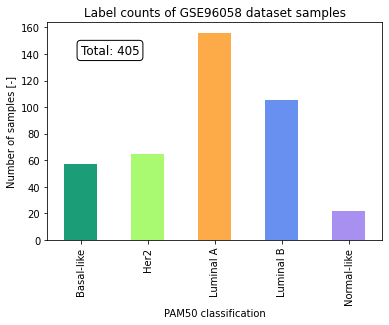

In [ ]:
gse81538_meta_df.groupby('PAM50')["Sample ID"].count().plot.bar(color=colors, title="Label counts of GSE96058 dataset samples", ylabel="Number of samples [-]", xlabel = "PAM50 classification").text(0, 140, f"Total: {gse81538_meta_df.shape[0]}",fontsize=12, bbox=dict(facecolor='none', edgecolor='black', boxstyle='round'))

In [ ]:
#gse81538_count_df.to_csv(f"{path}/all_processed/X_gse81538_BRCA.csv.tar.gz", compression = "gzip")
#gse81538_meta_df.to_csv(f"{path}/all_processed/y_gse81538_BRCA.csv.tar.gz", compression = "gzip")

In [ ]:
X_tr, X_t, y_tr, y_t = train_test_split(
        gse81538_count_df.T, gse81538_meta_df["PAM50"],
        train_size=0.90,
        test_size=0.10,
        random_state=23,
        stratify=gse81538_meta_df["PAM50"])

In [ ]:
round(y_tr.value_counts(normalize=True)*100,2)

Luminal A      38.46
Luminal B      25.82
Her2           16.21
Basal-like     14.01
Normal-like     5.49
Name: PAM50, dtype: float64

In [ ]:
round(y_t.value_counts(normalize=True)*100,2)

Luminal A      39.02
Luminal B      26.83
Basal-like     14.63
Her2           14.63
Normal-like     4.88
Name: PAM50, dtype: float64

In [ ]:
#X_tr.to_csv(f"{path}/training_data/X_gse81538_BRCA.csv.tar.gz", compression = "gzip")
#y_tr.to_csv(f"{path}/training_data/y_gse81538_BRCA.csv.tar.gz", compression = "gzip")
#X_t.to_csv(f"{path}/testing_data/X_gse81538_BRCA.csv.tar.gz", compression = "gzip")
#y_t.to_csv(f"{path}/testing_data/y_gse81538_BRCA.csv.tar.gz", compression = "gzip")

## NKI/TRANSBIG/UPP/UKT datasets

These datasets were loaded here by installing libraries - breastCancerNKI, breastCancerTRANSBIG, breastCancerUPP and breastCancerUNT. The data were loaded via data() and exprs() functions and saved to csv.


### Metadata

In [ ]:
dmeta_df = pd.read_csv(f"{path}/nki_upp_transbig_unt_labels.csv.zip", sep=";")
dmeta_df.columns = ["Sample ID", "Subtype"]
dmeta_df["Study ID"] = "NKI/TRANSBIG/UPP/UKT"
dmeta_df.tail()

Sample ID Subtype              Study ID
812   NKI_398   Basal  NKI/TRANSBIG/UPP/UKT
813   NKI_401    LumA  NKI/TRANSBIG/UPP/UKT
814   NKI_402   Basal  NKI/TRANSBIG/UPP/UKT
815   NKI_403    LumA  NKI/TRANSBIG/UPP/UKT
816   NKI_404    LumA  NKI/TRANSBIG/UPP/UKT

In [ ]:
dmeta_df.shape

(817, 3)

### Count matrices

In [ ]:
%%script false --no-raise-error
# the code below contains some preprocessing steps I used for NKI dataset in R
library(tibble)
library(dplyr)
library(breastCancerNKI)

data(nki)
t <- fData(nki)
t <- t[!is.na(t$Alternative.symbols),]
ts <- t %>% select("probe", "HUGO.gene.symbol")
data <- as.data.frame(exprs(nki))
data <- rownames_to_column(data, "ID")
final <- left_join(ts, data, by=c("probe"="ID"))
final <- final[!duplicated(final$HUGO.gene.symbol),]
final <- final[!is.na(final$HUGO.gene.symbol),]
rownames(final) <- 1:dim(final)[1]
final <- column_to_rownames(final, "HUGO.gene.symbol")
final <- final %>% select(-"probe")
#write.csv(final, "nki_count_matrix.csv", row.names = T)

#### NKI

In [ ]:
nki_count_df = pd.read_csv(f"{path}/NKI/nki_count_matrix.csv.zip", index_col=0)
nki_count_df.index.name = "hgnc_symbol"
nki_count_df = merge_counts(nki_count_df, df, "Hugo", "Entrez", "Affymetrix")
nki_count_df.head()

NKI_4  NKI_6  NKI_7  NKI_8  NKI_9  NKI_11  NKI_12  NKI_13  NKI_14  \
Entrez                                                                      
1      -0.050  0.125  0.426 -0.016  0.307  -0.310  -0.174   0.280   0.056   
2      -0.384 -0.314  0.053 -0.035 -0.169  -0.116   0.530  -0.122  -0.141   
9       0.087  0.491 -0.771 -0.507 -0.537  -0.136  -0.915  -0.340   0.659   
10      0.067 -0.027 -0.019 -0.129  0.098   0.001   0.100   0.086  -0.002   
12     -0.533  0.695  0.089  0.093  0.166  -0.759     NaN  -0.082  -0.306   

        NKI_17  ...  NKI_393  NKI_394  NKI_395  NKI_396  NKI_397  NKI_398  \
Entrez          ...                                                         
1        0.116  ...    0.054    0.048   -0.055   -0.120    0.202   -0.092   
2        0.074  ...   -0.173   -0.366   -0.090   -0.486   -0.327   -0.455   
9       -0.012  ...   -0.082   -0.422    0.031   -0.471    0.771   -0.693   
10       0.067  ...   -0.087    0.056   -0.086    0.059   -0.027   -0.282   
12       0.273  ...   -0.548    0.493    0.204   -0.769   -0.378   -0.619   

        NKI_401  NKI_402  NKI_403  NKI_404  
Entrez                                      
1         0.054   -0.067    0.345    0.442  
2        -0.664   -0.173   -0.091   -0.280  
9         0.112   -0.788    0.174   -0.282  
10       -0.112    0.103   -0.041    0.071  
12        0.597    0.305   -0.238    0.119  

[5 rows x 337 columns]

In [ ]:
nki_count_df.sort_index(inplace=True) 
nki_count_df.shape

(10808, 337)

In [ ]:
nki_meta = pd.DataFrame(nki_count_df.columns.tolist())
nki_meta.columns = ["Sample ID"]
nki_meta = process_metadata(nki_meta, "NKI", nki_count_df)
nki_meta.head()

Sample ID       PAM50 Study ID
0     NKI_4   Luminal B      NKI
1     NKI_6   Luminal A      NKI
2     NKI_7   Luminal A      NKI
3     NKI_8  Basal-like      NKI
4     NKI_9   Luminal B      NKI

In [ ]:
nki_count_df = nki_count_df[nki_meta["Sample ID"].tolist()]
nki_count_df.shape

(10808, 337)

In [ ]:
#nki_count_df.to_csv(f"{path}/all_processed/X_NKI_BRCA.csv.tar.gz", compression = "gzip")
#nki_meta.to_csv(f"{path}/all_processed/y_NKI_BRCA.csv.tar.gz", compression = "gzip")

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(
        nki_count_df.T, nki_meta["PAM50"],
        train_size=0.90,
        test_size=0.10,
        random_state=23,
        stratify=nki_meta["PAM50"])

In [ ]:
#x_train.to_csv(f"{path}/training_data/X_NKI_BRCA.csv.tar.gz", compression = "gzip")
#y_train.to_csv(f"{path}/training_data/y_NKI_BRCA.csv.tar.gz", compression = "gzip")
#x_test.to_csv(f"{path}/testing_data/X_NKI_BRCA.csv.tar.gz", compression = "gzip")
#y_test.to_csv(f"{path}/testing_data/y_NKI_BRCA.csv.tar.gz", compression = "gzip")

#### TRANSBIG

In [ ]:
transbig_count_df = pd.read_csv(f"{path}/TRANSBIG/breastCancerTransbig.csv.zip", index_col=0)
transbig_count_df.tail()

VDXGUYU_4002  VDXGUYU_4008  VDXGUYU_4011  VDXGUYU_4014  \
AFFX-ThrX-5_at       5.680176      2.888221      3.464008      5.564328   
AFFX-ThrX-M_at       1.753631      1.767325      4.875803      3.361199   
AFFX-TrpnX-3_at      2.223181      2.013092      0.581058      2.251075   
AFFX-TrpnX-5_at      4.013873      5.355048      4.054644      4.760490   
AFFX-TrpnX-M_at      1.603252      2.455589      2.021403      2.365204   

                 VDXGUYU_4022  VDXGUYU_4033  VDXGUYU_4034  VDXGUYU_4036  \
AFFX-ThrX-5_at       5.957565      1.740601      2.093126      3.763917   
AFFX-ThrX-M_at       2.400875      5.284490      4.893867      4.095883   
AFFX-TrpnX-3_at      4.915962      2.600288      1.879390      1.469121   
AFFX-TrpnX-5_at      6.120431      4.468676      3.794052      4.822143   
AFFX-TrpnX-M_at      2.774229      2.270242      1.925874      2.291870   

                 VDXGUYU_4040  VDXGUYU_4041  ...  VDXRHU_2587  VDXRHU_3642  \
AFFX-ThrX-5_at       4.399650      3.744013  ...     3.315229     3.002246   
AFFX-ThrX-M_at       5.130756      3.828155  ...     3.400638     1.624498   
AFFX-TrpnX-3_at      2.129731      4.025017  ...     3.254034     5.201070   
AFFX-TrpnX-5_at      3.711549      3.809851  ...     2.985075     1.985025   
AFFX-TrpnX-M_at      2.236214      1.542741  ...     2.523490     1.794379   

                 VDXRHU_4188  VDXRHU_5223  VDXRHU_5226  VDXRHU_5228  \
AFFX-ThrX-5_at      2.775177     1.804964     3.200786     3.553865   
AFFX-ThrX-M_at      6.247997     3.568859     5.336106     5.375497   
AFFX-TrpnX-3_at     1.566979     2.107088     1.059342     0.929578   
AFFX-TrpnX-5_at     2.898079     2.804893     5.234032     2.431918   
AFFX-TrpnX-M_at     2.754495     1.552359     2.281197     3.235379   

                 VDXRHU_5232  VDXRHU_5235  VDXRHU_5236  VDXRHU_5240  
AFFX-ThrX-5_at      2.859465     5.588937     3.120619     3.727378  
AFFX-ThrX-M_at      1.858311     4.302067     5.088536     2.742265  
AFFX-TrpnX-3_at     1.906231     4.468821     5.682201     2.349358  
AFFX-TrpnX-5_at     4.948435     5.678535     3.685063     1.658981  
AFFX-TrpnX-M_at     2.761732     3.143182     1.916516     1.403235  

[5 rows x 198 columns]

In [ ]:
transbig_count_df = merge_counts(transbig_count_df, df, "Affymetrix", "Entrez", "Hugo")
transbig_count_df.shape

(13307, 198)

In [ ]:
transbig_meta = pd.DataFrame(transbig_count_df.columns.tolist())
transbig_meta.columns = ["Sample ID"]
transbig_meta = process_metadata(transbig_meta, "TRANSBIG", transbig_count_df)
transbig_meta.head()

Sample ID       PAM50  Study ID
0  VDXGUYU_4002        Her2  TRANSBIG
1  VDXGUYU_4008   Luminal B  TRANSBIG
2  VDXGUYU_4011  Basal-like  TRANSBIG
3  VDXGUYU_4014   Luminal B  TRANSBIG
4  VDXGUYU_4022   Luminal B  TRANSBIG

In [ ]:
#transbig_count_df.to_csv(f"{path}/all_processed/X_TRANSBIG_BRCA.csv.tar.gz", compression = "gzip")
#transbig_meta.to_csv(f"{path}/all_processed/y_TRANSBIG_BRCA.csv.tar.gz", compression = "gzip")

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(
        transbig_count_df.T, transbig_meta["PAM50"],
        train_size=0.90,
        test_size=0.10,
        random_state=23,
        stratify=transbig_meta["PAM50"])

In [ ]:
#x_train.to_csv(f"{path}/training_data/X_TRANSBIG_BRCA.csv.tar.gz", compression = "gzip")
#y_train.to_csv(f"{path}/training_data/y_TRANSBIG_BRCA.csv.tar.gz", compression = "gzip")
#x_test.to_csv(f"{path}/testing_data/X_TRANSBIG_BRCA.csv.tar.gz", compression = "gzip")
#y_test.to_csv(f"{path}/testing_data/y_TRANSBIG_BRCA.csv.tar.gz", compression = "gzip")

#### UPP

In [ ]:
upp_count_df = pd.read_csv(f"{path}/UPP/breastCancerUpp.csv.zip", index_col=0)
upp_count_df = merge_counts(upp_count_df, df, "Affymetrix", "Entrez", "Hugo")
upp_count_df.head()

UPP_103B41  UPP_104B91  UPP_112B55  UPP_114B68  UPP_130B92  \
Entrez                                                               
1            6.750       7.356       7.631       7.189       7.333   
2            9.540       9.378       9.885       8.914       9.425   
9            6.472      10.328       9.759       9.238      10.609   
10           4.357       7.784       3.742       6.197       4.394   
12          10.662      10.611       8.251       9.716      10.831   

        UPP_131B79  UPP_135B40  UPP_138B34  UPP_139B03  UPP_147B19  ...  \
Entrez                                                              ...   
1            7.333       7.239       7.090       6.199       6.867  ...   
2            9.973       9.839       9.713       9.801       9.540  ...   
9            8.792       8.213      10.226       8.286       6.855  ...   
10           3.944       4.589       6.470       4.353       5.120  ...   
12          10.095       9.740      10.131       9.102       6.915  ...   

        UPP_73A01  UPP_74A63  UPP_75A01  UPP_86A40  UPP_87A79  UPP_88A67  \
Entrez                                                                     
1           6.429      6.541      7.295      6.435      7.079      7.326   
2          10.111      9.388      9.524      9.093      9.957      9.582   
9           7.230      9.933      9.714      5.753      7.415      9.183   
10          5.299      4.934      5.106      4.332      4.775      4.413   
12          8.038      9.877      9.275      6.962      8.772      9.729   

        UPP_90A63  UPP_94A16  UPP_99A50  UPP_9B52  
Entrez                                             
1           7.582      6.557      7.136     7.174  
2           9.719     10.155      9.832     9.666  
9           9.903     10.199      8.741     8.873  
10          5.444      4.775      3.694     6.050  
12          9.280     10.699      9.938    10.605  

[5 rows x 251 columns]

In [ ]:
upp_count_df.shape

(18639, 251)

In [ ]:
upp_meta = pd.DataFrame(upp_count_df.columns.tolist())
upp_meta.columns = ["Sample ID"]
upp_meta = process_metadata(upp_meta, "UPP", upp_count_df)
upp_meta.head()

Sample ID       PAM50 Study ID
0  UPP_103B41  Basal-like      UPP
1  UPP_104B91   Luminal B      UPP
2  UPP_112B55   Luminal B      UPP
3  UPP_114B68   Luminal B      UPP
4  UPP_130B92   Luminal A      UPP

In [ ]:
upp_count_df = upp_count_df[upp_meta["Sample ID"].tolist()]

In [ ]:
#upp_count_df.to_csv(f"{path}/all_processed/X_UPP_BRCA.csv.tar.gz", compression = "gzip")
#upp_meta.to_csv(f"{path}/all_processed/y_UPP_BRCA.csv.tar.gz", compression = "gzip")

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(
        upp_count_df.T, upp_meta["PAM50"],
        train_size=0.90,
        test_size=0.10,
        random_state=23,
        stratify=upp_meta["PAM50"])

In [ ]:
#x_train.to_csv(f"{path}/training_data/X_UPP_BRCA.csv.tar.gz", compression = "gzip")
#y_train.to_csv(f"{path}/training_data/y_UPP_BRCA.csv.tar.gz", compression = "gzip")
#x_test.to_csv(f"{path}/testing_data/X_UPP_BRCA.csv.tar.gz", compression = "gzip")
#y_test.to_csv(f"{path}/testing_data/y_UPP_BRCA.csv.tar.gz", compression = "gzip")

#### UNT

In [ ]:
unt_count_df = pd.read_csv(f"{path}/UNT/breastCancerUNT.csv.zip", index_col=0)
unt_count_df = merge_counts(unt_count_df, df, "Affymetrix", "Entrez", "Hugo")
unt_count_df.shape

(18639, 137)

In [ ]:
unt_meta = pd.DataFrame(unt_count_df.columns.tolist())
unt_meta.columns = ["Sample ID"]
unt_meta = process_metadata(unt_meta, "UNT", unt_count_df)
unt_meta.head()

Sample ID      PAM50 Study ID
3    OXFU_12  Luminal A      UNT
5  OXFU_1248  Luminal A      UNT
6   OXFU_126  Luminal B      UNT
7   OXFU_127  Luminal A      UNT
8  OXFU_1286  Luminal B      UNT

In [ ]:
unt_count_df = unt_count_df[unt_meta["Sample ID"].tolist()]

In [ ]:
#unt_count_df.to_csv(f"{path}/all_processed/X_UNT_BRCA.csv.tar.gz", compression = "gzip")
#unt_meta.to_csv(f"{path}/all_processed/y_UNT_BRCA.csv.tar.gz", compression = "gzip")

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(
        unt_count_df.T, unt_meta["PAM50"],
        train_size=0.90,
        test_size=0.10,
        random_state=23,
        stratify=unt_meta["PAM50"])

In [ ]:
#x_train.to_csv(f"{path}/training_data/X_UNT_BRCA.csv.tar.gz", compression = "gzip")
#y_train.to_csv(f"{path}/training_data/y_UNT_BRCA.csv.tar.gz", compression = "gzip")
#x_test.to_csv(f"{path}/testing_data/X_UNT_BRCA.csv.tar.gz", compression = "gzip")
#y_test.to_csv(f"{path}/testing_data/y_UNT_BRCA.csv.tar.gz", compression = "gzip")

### Label counts total

In [ ]:
upp_unt_transbig_nki = unt_meta.append(upp_meta).append(transbig_meta).append(nki_meta)

Text(0, 280, 'Total: 817')

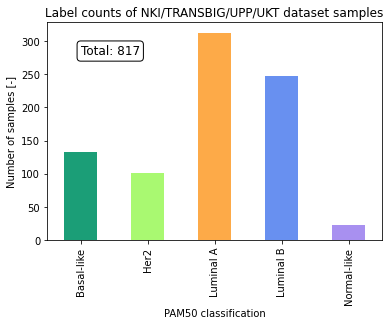

In [ ]:
upp_unt_transbig_nki.groupby('PAM50')["Sample ID"].count().plot.bar(color=colors, title="Label counts of NKI/TRANSBIG/UPP/UKT dataset samples", ylabel="Number of samples [-]", xlabel = "PAM50 classification").text(0, 280, f"Total: {dmeta_df.shape[0]}",fontsize=12, bbox=dict(facecolor='none', edgecolor='black', boxstyle='round'))

## ROCK (GSE47561)

Metadta were taken from the paper, while data were loaded as a single file from GEO.

### Metadata

In [ ]:
rock_meta_df = pd.read_csv(f"{path}/ROCK/ROCK_labels.csv.zip",sep=";")
rock_meta_df = rock_meta_df[rock_meta_df["Subtype"] != "INC"]
rock_meta_df["PAM50"] = rock_meta_df["Subtype"].map(chnge_label)
rock_meta_df = rock_meta_df.drop("Subtype", axis=1)
rock_meta_df["Study ID"] = "ROCK"
rock_meta_df.head()

Sample ID      PAM50 Study ID
0  GSM107072  Luminal A     ROCK
1  GSM107073  Luminal B     ROCK
2  GSM107075  Luminal A     ROCK
3  GSM107076  Luminal A     ROCK
4  GSM107077  Luminal B     ROCK

### Count matrix

In [ ]:
rock_count_df = pd.read_csv(f"{path}/ROCK/GSE47561_log2_RMA_renormalized_data.txt.zip", sep="\t", index_col=[0], skiprows=1)
rock_count_df = merge_counts(rock_count_df, df, "Affymetrix", "Entrez", "Hugo")
rock_count_df.shape

(13307, 1570)

In [ ]:
rock_count_df = rock_count_df[rock_meta_df["Sample ID"].tolist()]
rock_count_df = rock_count_df[rock_count_df.index != ""]
rock_count_df.head()

GSM107072  GSM107073  GSM107075  GSM107076  GSM107077  GSM107078  \
Entrez                                                                     
2       10.526080   9.157664  11.255843  11.411395   8.773838  10.567499   
9        7.843712  12.430300  10.806620  10.532619   7.956286  12.151120   
10       2.221335   2.221335   2.221335   2.221335   2.221335   2.221335   
12      10.901601  13.198199   8.224007  12.627136   8.772403  13.160761   
13       2.221335   2.221335   2.221335   2.221335   2.221335   2.221335   

        GSM107079  GSM107080  GSM107081  GSM107082  ...   GSM65870   GSM65871  \
Entrez                                              ...                         
2       11.331141  11.154806  11.409200  10.304763  ...  10.408770  11.587926   
9       13.065102   4.066067   8.078012   5.677286  ...  10.015693   8.396949   
10       2.221335   2.221335   2.221335   2.221335  ...   2.221335   2.221335   
12       9.274009   2.844708   9.417477   9.409690  ...   7.866320  12.914322   
13       2.221335   2.221335   2.221335   2.221335  ...   2.221335   2.221335   

         GSM65872   GSM65873   GSM65874   GSM65875   GSM65877   GSM65878  \
Entrez                                                                     
2       10.793837  10.495333  11.735920   9.775713  11.228324  10.606513   
9       10.042489  11.397856   8.090137  10.817385  10.556629   4.241047   
10       2.221335   2.221335   2.221335   2.221335   2.221335   2.221335   
12      10.899389  12.372636  10.819579  11.713218  12.225192   9.876904   
13       2.221335   2.221335   2.221335   2.221335   2.221335   2.221335   

         GSM65879   GSM65880  
Entrez                        
2       10.550262  10.911739  
9        6.268133   8.006762  
10       2.221335   2.221335  
12       6.916557  11.963537  
13       2.540122   2.221335  

[5 rows x 1468 columns]

In [ ]:
rock_meta_df.groupby("PAM50")["Sample ID"].count()

PAM50
Basal-like     242
Her2            69
Luminal A      688
Luminal B      377
Normal-like     92
Name: Sample ID, dtype: int64

Text(0, 630, 'Total: 1468')

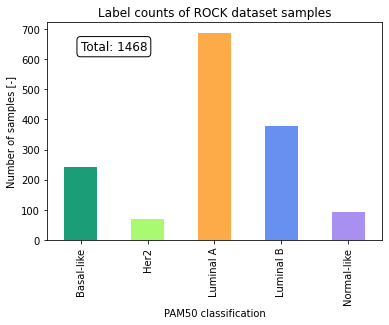

In [ ]:
rock_meta_df.groupby('PAM50')["Sample ID"].count().plot.bar(color=colors, title="Label counts of ROCK dataset samples", ylabel="Number of samples [-]", xlabel = "PAM50 classification").text(0, 630, f"Total: {rock_meta_df.shape[0]}",fontsize=12, bbox=dict(facecolor='none', edgecolor='black', boxstyle='round'))

In [ ]:
#rock_count_df.to_csv(f"{path}/all_processed/X_ROCK_BRCA.csv.tar.gz", compression = "gzip")
#rock_meta_df.to_csv(f"{path}/all_processed/y_ROCK_BRCA.csv.tar.gz", compression = "gzip")

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
        rock_count_df.T, rock_meta_df["PAM50"],
        train_size=0.90,
        test_size=0.10,
        random_state=23,
        stratify=rock_meta_df["PAM50"])

In [ ]:
round(y_test.value_counts(normalize=True)*100,2)

Luminal A      46.94
Luminal B      25.85
Basal-like     16.33
Normal-like     6.12
Her2            4.76
Name: PAM50, dtype: float64

In [ ]:
round(y_train.value_counts(normalize=True)*100,2)

Luminal A      46.86
Luminal B      25.66
Basal-like     16.50
Normal-like     6.28
Her2            4.69
Name: PAM50, dtype: float64

In [ ]:
#X_train.to_csv(f"{path}/training_data/X_ROCK_BRCA.csv.tar.gz", compression = "gzip")
#y_train.to_csv(f"{path}/training_data/y_ROCK_BRCA.csv.tar.gz", compression = "gzip")
#X_test.to_csv(f"{path}/testing_data/X_ROCK_BRCA.csv.tar.gz", compression = "gzip")
#y_test.to_csv(f"{path}/testing_data/y_ROCK_BRCA.csv.tar.gz", compression = "gzip")

## Generation of final metadata and count tables

### Final metadata

Below I will check consistency of column names.

In [ ]:
print("TCGA - ", tcga_meta_df.columns.tolist())
print("METABRIC - ", metabric_meta_df.columns.tolist())
print("CPTAC - ", cptac_meta_df.columns.tolist())
print("SMC 2018 - ", smc2018_meta_df.columns.tolist())
print("GSE96058 - ", gse96058_meta_df.columns.tolist())
print("GSE81538 - ", gse81538_meta_df.columns.tolist())
print("NKI", nki_meta.columns.tolist())
print("TRASBIG", transbig_meta.columns.tolist())
print("UPP", upp_meta.columns.tolist())
print("UPT", unt_meta.columns.tolist())
print("ROCK", rock_meta_df.columns.tolist())

TCGA -  ['Sample ID', 'PAM50', 'Study ID']
METABRIC -  ['Sample ID', 'PAM50', 'Study ID']
CPTAC -  ['Sample ID', 'PAM50', 'Study ID']
SMC 2018 -  ['Sample ID', 'PAM50', 'Study ID']
GSE96058 -  ['Sample ID', 'PAM50', 'Study ID']
GSE81538 -  ['Sample ID', 'PAM50', 'Study ID']
NKI ['Sample ID', 'PAM50', 'Study ID']
TRASBIG ['Sample ID', 'PAM50', 'Study ID']
UPP ['Sample ID', 'PAM50', 'Study ID']
UPT ['Sample ID', 'PAM50', 'Study ID']
ROCK ['Sample ID', 'PAM50', 'Study ID']


In [ ]:
final_meta_df = pd.concat([tcga_meta_df, metabric_meta_df, cptac_meta_df, smc2018_meta_df, gse96058_meta_df, gse81538_meta_df, upp_meta, transbig_meta, nki_meta, unt_meta, rock_meta_df])
final_meta_df.shape

(9132, 3)

In [ ]:
final_meta_df.isna().sum()

Sample ID    0
PAM50        0
Study ID     0
dtype: int64

In [ ]:
#final_meta_df.to_csv(f"{path}/metadata_breast_combined_no_geo.csv", index=False)

### Final count matrix

Below I will check the consistency of row names in different datasets.

In [ ]:
print("TCGA - ", tcga_count_df.axes[0].tolist()[:5])
print("METABRIC - ", metabric_count_df.axes[0].tolist()[:5])
print("CPTAC - ", cptac_count_df.axes[0].tolist()[:5])
print("SMC 2018 - ", smc2018_count_df.axes[0].tolist()[:5])
print("GSE96058 - ", gse96058_count_df.axes[0].tolist()[:5])
print("GSE81538 - ", gse81538_count_df.axes[0].tolist()[:5])
print("NKI", nki_count_df.axes[0].tolist()[:5])
print("TRANSBIG", transbig_count_df.axes[0].tolist()[:5])
print("UPP", upp_count_df.axes[0].tolist()[:5])
print("UNT", unt_count_df.axes[0].tolist()[:5])
print("ROCK - ", rock_count_df.axes[0].tolist()[:5])

TCGA -  [1, 2, 9, 10, 12]
METABRIC -  [1, 2, 9, 10, 12]
CPTAC -  [1, 2, 9, 10, 12]
SMC 2018 -  [1, 2, 9, 10, 12]
GSE96058 -  [1, 2, 9, 10, 12]
GSE81538 -  [1, 2, 9, 10, 12]
NKI [1, 2, 9, 10, 12]
TRANSBIG [2, 9, 10, 12, 13]
UPP [1, 2, 9, 10, 12]
UNT [1, 2, 9, 10, 12]
ROCK -  [2, 9, 10, 12, 13]


In [ ]:
print("TCGA - ", tcga_count_df.shape)
print("METABRIC - ", metabric_count_df.shape)
print("CPTAC - ", cptac_count_df.shape)
print("SMC 2018 - ", smc2018_count_df.shape)
print("GSE96058 - ", gse96058_count_df.shape)
print("GSE81538 - ", gse81538_count_df.shape)
print("NKI", nki_count_df.shape)
print("TRANSBIG", transbig_count_df.shape)
print("UPP", upp_count_df.shape)
print("UNT", unt_count_df.shape)
print("ROCK - ", rock_count_df.shape)

TCGA -  (20531, 1082)
METABRIC -  (18207, 1904)
CPTAC -  (17419, 122)
SMC 2018 -  (17540, 168)
GSE96058 -  (17988, 3273)
GSE81538 -  (16284, 405)
NKI (10808, 337)
TRANSBIG (13307, 198)
UPP (18639, 190)
UNT (18639, 92)
ROCK -  (13307, 1468)


In [ ]:
counts_breast_combined =  gse96058_count_df.merge(metabric_count_df, left_index=True, right_index=True, how="left") \
                                          .merge(cptac_count_df, left_index=True, right_index=True, how="left") \
                                          .merge(smc2018_count_df, left_index=True, right_index=True, how="left") \
                                          .merge(rock_count_df, left_index=True, right_index=True, how="left") \
                                          .merge(gse81538_count_df, left_index=True, right_index=True, how="left") \
                                          .merge(upp_count_df, left_index=True, right_index=True, how="left") \
                                          .merge(tcga_count_df, left_index=True, right_index=True, how="left") \
                                          .merge(transbig_count_df, left_index=True, right_index=True, how="left") \
                                          .merge(nki_count_df, left_index=True, right_index=True, how="left") \
                                          .merge(unt_count_df, left_index=True, right_index=True, how="left")

In [ ]:
counts_breast_combined.shape

(18010, 9239)

In [ ]:
final_meta_df = final_meta_df[final_meta_df["Sample ID"].isin(counts_breast_combined.columns)]
#final_meta_df.to_csv(f"{path}/metadata_breast_combined_no_geo.csv", index=False)
counts_breast_combined = counts_breast_combined[final_meta_df["Sample ID"].tolist()]

In [ ]:
counts_breast_combined.shape

(18010, 9132)

In [ ]:
counts_breast_combined.head()

TCGA-3C-AAAU-01  TCGA-3C-AALI-01  TCGA-3C-AALJ-01  TCGA-3C-AALK-01  \
1            0.4344           0.6644           1.3806           0.3957   
2           -0.9636          -0.5790          -0.3558          -0.0460   
9            1.2045          -0.1725           0.2166           0.1931   
10           0.4247           2.1151          -1.1072           0.3018   
12           0.3958          -2.8225           0.0803           0.2354   

    TCGA-4H-AAAK-01  TCGA-5L-AAT0-01  TCGA-5T-A9QA-01  TCGA-A1-A0SB-01  \
1            0.8186           0.4756           1.0114          -1.2713   
2           -0.2392           0.1239          -1.8280           1.4813   
9           -0.9395          -0.0174           0.0562          -1.3572   
10          -1.1322           0.5353          -0.3519          -0.9300   
12           0.0608           0.3638          -1.5796          -0.7507   

    TCGA-A1-A0SD-01  TCGA-A1-A0SE-01  ...   GSM65870   GSM65871   GSM65872  \
1            0.0320           0.4073  ...        NaN        NaN        NaN   
2            1.0711           0.4746  ...  10.408770  11.587926  10.793837   
9            0.4348           0.8439  ...  10.015693   8.396949  10.042489   
10           0.2292           0.2548  ...   2.221335   2.221335   2.221335   
12           1.3426           0.8384  ...   7.866320  12.914322  10.899389   

     GSM65873   GSM65874   GSM65875   GSM65877   GSM65878   GSM65879  \
1         NaN        NaN        NaN        NaN        NaN        NaN   
2   10.495333  11.735920   9.775713  11.228324  10.606513  10.550262   
9   11.397856   8.090137  10.817385  10.556629   4.241047   6.268133   
10   2.221335   2.221335   2.221335   2.221335   2.221335   2.221335   
12  12.372636  10.819579  11.713218  12.225192   9.876904   6.916557   

     GSM65880  
1         NaN  
2   10.911739  
9    8.006762  
10   2.221335  
12  11.963537  

[5 rows x 9132 columns]

In [ ]:
counts_breast_combined = counts_breast_combined.fillna(0)
counts_breast_combined.to_csv(f"{path}/counts_breast_combined_no_geo.csv.tar.gz", compression="gzip", index=True)

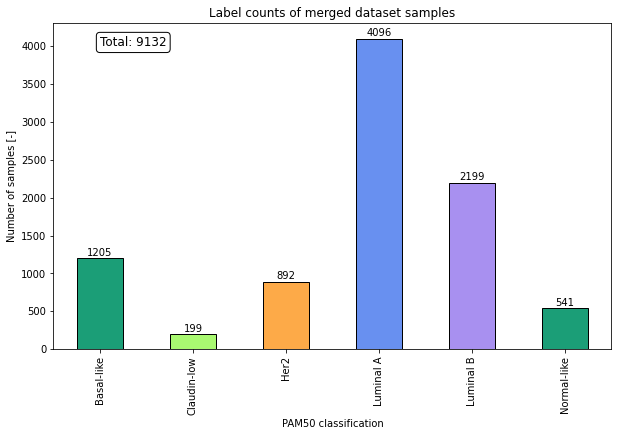

In [ ]:
frequencies = final_meta_df.groupby('PAM50')["Sample ID"].count().tolist()
freq_series = pd.Series(frequencies)
x_labels = final_meta_df.groupby('PAM50')["Sample ID"].count().index.tolist()

plt.figure(figsize=(10, 6))
ax = freq_series.plot(kind="bar", color=colors, edgecolor = "black")
ax.set_title("Label counts of merged dataset samples")
ax.set_xlabel("PAM50 classification")
ax.set_ylabel("Number of samples [-]")
ax.set_xticklabels(x_labels)

rects = ax.patches

for rect, label in zip(rects, x_labels):
    height = rect.get_height()
    ax.text(
        rect.get_x() + rect.get_width() / 2, height + 5, height, ha="center", va="bottom"
    )
ax.text(0, 4000, f"Total: {final_meta_df.shape[0]}",fontsize=12, bbox=dict(facecolor='none', edgecolor='black', boxstyle='round'))
plt.show()

Removing NANs and duplicated values.

## PCA

In [ ]:
counts_breast_combined =  pd.read_csv(f"/home/simonova/counts_breast_combined_no_geo.csv.tar.gz", compression="gzip", index_col=0)
counts_breast_combined.shape

(18010, 9132)

In [ ]:
final_labels_df = pd.read_csv(f"/home/simonova/metadata_breast_combined_no_geo.csv")
final_labels_df.head()

Sample ID      PAM50 Study ID
0  TCGA-3C-AAAU-01  Luminal A     TCGA
1  TCGA-3C-AALI-01       Her2     TCGA
2  TCGA-3C-AALJ-01  Luminal B     TCGA
3  TCGA-3C-AALK-01  Luminal A     TCGA
4  TCGA-4H-AAAK-01  Luminal A     TCGA

In [ ]:
final_labels_df.groupby("Study ID")["Sample ID"].count()

Study ID
CPTAC        122
GSE81538     405
GSE96058    3273
METABRIC    1898
NKI          337
ROCK        1468
TCGA         981
TRANSBIG     198
UNT           92
UPP          190
smc_2018     168
Name: Sample ID, dtype: int64

In [ ]:
final_labels_df[final_labels_df['PAM50'].isna()]

Empty DataFrame
Columns: [Sample ID, PAM50, Study ID]
Index: []

In [ ]:
merged_df = counts_breast_combined
merged_df = merged_df.fillna(0)
merged_df.shape

(18010, 9132)

In [ ]:
merged_df.isna().sum().sum()

0

In [ ]:
final_labels_df.PAM50 = final_labels_df.PAM50.astype('category')
final_labels_df["Study ID"] = final_labels_df["Study ID"].astype('category')
final_labels_df.shape

(9132, 3)

In [ ]:
comp, labels = scale_pca(merged_df.T)

In [ ]:
fig = px.scatter_matrix(
    comp,
    labels=labels,
    dimensions=range(2),
    color = final_labels_df["Study ID"]
)

fig.layout.legend.y = 1.05
fig.layout.legend.x = 1.035

fig.update_traces(diagonal_visible=False)
fig.show()

/home/simonova/.local/lib/python3.10/site-packages/plotly/express/_core.py:279: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  dims = [


In [ ]:
fig = px.scatter_matrix(
    comp,
    labels=labels,
    dimensions=range(2),
    color=final_labels_df["PAM50"],
)

fig.layout.legend.y = 1.05
fig.layout.legend.x = 1.035

fig.update_traces(diagonal_visible=False)
fig.show()

/home/simonova/.local/lib/python3.10/site-packages/plotly/express/_core.py:279: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.



In [ ]:
final_labels_df.columns = ["Sample ID", "Label", "Dataset"]
final_labels_df["Platform"] = final_labels_df["Dataset"].map(d_ilmn)
final_labels_df.head()

Sample ID      Label Dataset        Platform
0  TCGA-3C-AAAU-01  Luminal A    TCGA  RNA sequencing
1  TCGA-3C-AALI-01       Her2    TCGA  RNA sequencing
2  TCGA-3C-AALJ-01  Luminal B    TCGA  RNA sequencing
3  TCGA-3C-AALK-01  Luminal A    TCGA  RNA sequencing
4  TCGA-4H-AAAK-01  Luminal A    TCGA  RNA sequencing

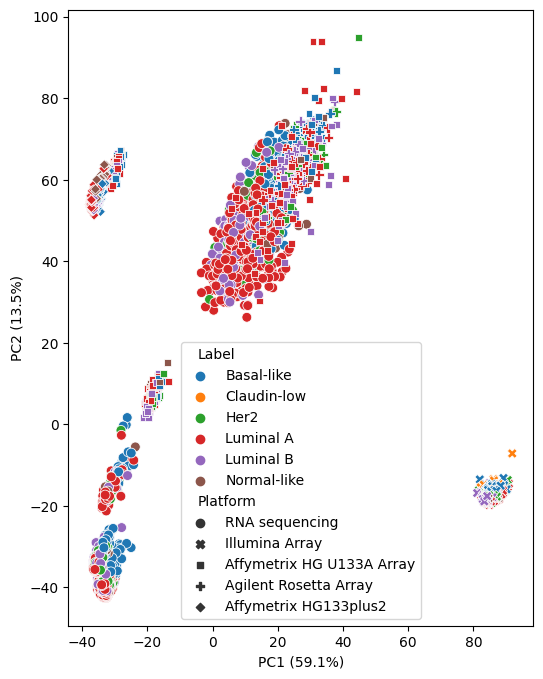

In [ ]:
plt.figure(figsize=(6,8))
components_df = pd.DataFrame(comp)
components_df.columns = [f"PC{i+1}" for i in components_df.columns]
components_df.index = final_labels_df["Sample ID"]
c_df = pd.merge(components_df, final_labels_df, left_index=True, right_on="Sample ID", how="left")
#c_df
sns.scatterplot(x="PC1", y="PC2", s=50, hue="Label", style="Platform",  data=c_df) #
plt.xlabel("PC1 (59.1%)")
plt.ylabel("PC2 (13.5%)")
plt.show()

The problem what was observed is that different method Affymetrix Array, Agilent Array and RNAseq bring technical variability that is higher than variability in subtypes (upper graph). In order to overcome the issue the data will be trandfermed to a functional spectrum, and then used for train_test_split and modeling.

## DeepCC samples all above-loaded datasets

For this part it is needed to swith to HP server.

In [ ]:
train = pd.read_csv(f"{path}/method_A/training_data/X_train_A_merged_CRC_BRCA.csv.tar.gz", compression = "gzip", index_col=0)
val = pd.read_csv(f"{path}/method_A/validation_data/X_test_A_merged_CRC_BRCA.csv.tar.gz", compression = "gzip", index_col=0)
test = pd.read_csv(f"{path}/method_A/testing_data/X_test_A_merged_CRC_BRCA.csv.tar.gz", compression = "gzip", index_col=0)

In [ ]:
data_df = train.append(val).append(test)
data_df.index.name = "Geneset"
data_df.shape

In [ ]:
data_df.shape

(9132, 22596)

In [ ]:
# presort index na zaklade slopce metadata_df Sample ID
data_df = data_df.reindex(final_labels_df["Sample ID"].tolist())
data_df.head()

AAACCAC_MIR140  AAAGACA_MIR511  AAAGGAT_MIR501  \
Geneset                                                           
TCGA-3C-AAAU-01       -0.233057        0.216475        0.238510   
TCGA-3C-AALI-01       -0.286129       -0.267151       -0.355268   
TCGA-3C-AALJ-01       -0.283829       -0.357514       -0.305816   
TCGA-3C-AALK-01       -0.272108        0.268191       -0.231320   
TCGA-4H-AAAK-01        0.190083       -0.182739       -0.221206   

                 AAAGGGA_MIR204_MIR211  AAANWWTGC_UNKNOWN  AAAYRNCTG_UNKNOWN  \
Geneset                                                                        
TCGA-3C-AAAU-01              -0.241267          -0.256076           0.184008   
TCGA-3C-AALI-01              -0.299427          -0.203138          -0.187867   
TCGA-3C-AALJ-01              -0.307056          -0.325626          -0.221083   
TCGA-3C-AALK-01               0.185499           0.261755           0.260398   
TCGA-4H-AAAK-01               0.196688           0.239159           0.249880   

                 AAAYWAACM_HFH4_01  AACATTC_MIR4093P  AACGGTT_MIR451  \
Geneset                                                                
TCGA-3C-AAAU-01          -0.251556         -0.256062        0.259793   
TCGA-3C-AALI-01           0.212820         -0.355532       -0.528892   
TCGA-3C-AALJ-01          -0.261614         -0.300425       -0.317091   
TCGA-3C-AALK-01           0.275368         -0.206040       -0.515213   
TCGA-4H-AAAK-01           0.270048         -0.255958       -0.228090   

                 AACTGAC_MIR223  ...  ZIRN_TRETINOIN_RESPONSE_WT1_UP  \
Geneset                          ...                                   
TCGA-3C-AAAU-01       -0.274562  ...                       -0.470621   
TCGA-3C-AALI-01       -0.372047  ...                        0.242388   
TCGA-3C-AALJ-01       -0.346368  ...                       -0.351628   
TCGA-3C-AALK-01       -0.268073  ...                        0.293519   
TCGA-4H-AAAK-01       -0.234445  ...                        0.485550   

                 ZWANG_CLASS_1_TRANSIENTLY_INDUCED_BY_EGF  \
Geneset                                                     
TCGA-3C-AAAU-01                                 -0.288894   
TCGA-3C-AALI-01                                 -0.233236   
TCGA-3C-AALJ-01                                 -0.254471   
TCGA-3C-AALK-01                                  0.233277   
TCGA-4H-AAAK-01                                  0.180977   

                 ZWANG_CLASS_2_TRANSIENTLY_INDUCED_BY_EGF  \
Geneset                                                     
TCGA-3C-AAAU-01                                 -0.364737   
TCGA-3C-AALI-01                                 -0.286863   
TCGA-3C-AALJ-01                                 -0.147885   
TCGA-3C-AALK-01                                  0.370122   
TCGA-4H-AAAK-01                                  0.420450   

                 ZWANG_CLASS_3_TRANSIENTLY_INDUCED_BY_EGF  \
Geneset                                                     
TCGA-3C-AAAU-01                                 -0.380359   
TCGA-3C-AALI-01                                 -0.238193   
TCGA-3C-AALJ-01                                 -0.292712   
TCGA-3C-AALK-01                                  0.331299   
TCGA-4H-AAAK-01                                  0.200238   

                 ZWANG_DOWN_BY_2ND_EGF_PULSE  ZWANG_EGF_INTERVAL_DN  \
Geneset                                                               
TCGA-3C-AAAU-01                     0.429215               0.202659   
TCGA-3C-AALI-01                     0.276984               0.226118   
TCGA-3C-AALJ-01                     0.228224              -0.209983   
TCGA-3C-AALK-01                     0.181364               0.394758   
TCGA-4H-AAAK-01                     0.327223               0.334255   

                 ZWANG_EGF_INTERVAL_UP  ZWANG_EGF_PERSISTENTLY_DN  \
Geneset                                                             
TCGA-3C-AAAU-01               0.291314                  

In [ ]:
final_labels_df.shape

Sample ID      Label Dataset        Platform
0  TCGA-3C-AAAU-01  Luminal A    TCGA  RNA sequencing
1  TCGA-3C-AALI-01       Her2    TCGA  RNA sequencing
2  TCGA-3C-AALJ-01  Luminal B    TCGA  RNA sequencing
3  TCGA-3C-AALK-01  Luminal A    TCGA  RNA sequencing
4  TCGA-4H-AAAK-01  Luminal A    TCGA  RNA sequencing

In [ ]:
data_df.to_csv(f"{path}/BRCA/DeepCC_processed/counts_breast_combined_no_geo.csv.gz",compression="gzip", index=True)

### PCA

In [ ]:
comp_dc, labels_dc = scale_pca(data_df)

In [ ]:
fig = px.scatter_matrix(
    comp_dc,
    labels=labels_dc,
    dimensions=range(2),
    color=final_labels_df["Label"],
)

fig.layout.legend.y = 1.05
fig.layout.legend.x = 1.035

fig.update_traces(diagonal_visible=False)
fig.show()

/home/simonova/.local/lib/python3.10/site-packages/plotly/express/_core.py:279: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.



In [ ]:
fig = px.scatter_matrix(
    comp_dc,
    labels=labels_dc,
    dimensions=range(4),
    color = final_labels_df["Dataset"]
)

fig.layout.legend.y = 1.05
fig.layout.legend.x = 1.035

fig.update_traces(diagonal_visible=False)
fig.show()

/home/simonova/.local/lib/python3.10/site-packages/plotly/express/_core.py:279: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.



### tSNE

In [ ]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=0, perplexity=50)
projections = tsne.fit_transform(data_df)

In [ ]:
fig = px.scatter(
    projections, x=0, y=1,
    color=final_labels_df["Label"], width=800, height=700,
)
fig.show()

In [ ]:
fig = px.scatter(
    projections, x=0, y=1,
    color=final_labels_df["Dataset"], width=1100, height=700,
)
fig.show()

### UMAP

In [ ]:
from umap import UMAP

umap_2d = UMAP(n_components=2, init='random', random_state=0)
#umap_3d = UMAP(n_components=3, init='random', random_state=0)

proj_2d = umap_2d.fit_transform(data_df)
#proj_3d = umap_3d.fit_transform(final_brca_df)

In [ ]:
fig_2d = px.scatter(
    proj_2d, x=0, y=1,
    color=final_labels_df["Label"], labels={'color': 'Label'}
)
fig_2d.show()

In [ ]:
fig_2d = px.scatter(
    proj_2d, x=0, y=1,
    color=final_labels_df["Dataset"], labels={'color': 'Label'}
)
fig_2d.show()